In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RAW_DIR = Path("../input/raw")

In [3]:
train_data = pd.read_csv(RAW_DIR / "train.csv")
test_data = pd.read_csv(RAW_DIR / "test.csv")

## Train Data EDA

In [4]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Creating title column
train_data["Title"] = train_data["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

In [7]:
# Dropping PassengerId, Name, Ticket, Cabin (A lot of missing values)
train_data.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)

In [8]:
# Turning Cabin into a binary feature has_cabin
train_data["has_cabin"] = train_data["Cabin"].notna().astype(int)

test_data["has_cabin"] = test_data["Cabin"].notna().astype(int)

In [9]:
# Convert Pclass to ordinal categorical, Sex to categorical
# Embarked to categorical and Title to categorical
train_data["Pclass"] = pd.Categorical(
    train_data["Pclass"],
    categories=[1, 2, 3],
    ordered=True
)
train_data["Sex"] = pd.Categorical(train_data["Sex"])
train_data["Embarked"] = pd.Categorical(train_data["Embarked"])
train_data["Title"] = pd.Categorical(train_data["Title"])

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    category
 2   Sex        891 non-null    category
 3   Age        714 non-null    float64 
 4   SibSp      891 non-null    int64   
 5   Parch      891 non-null    int64   
 6   Fare       891 non-null    float64 
 7   Cabin      204 non-null    object  
 8   Embarked   889 non-null    category
 9   Title      891 non-null    category
 10  has_cabin  891 non-null    int64   
dtypes: category(4), float64(2), int64(4), object(1)
memory usage: 53.4+ KB


## Filling missing values

### Checking correlation between Age and Other features to fill missing values

In [11]:
# Check correlation between Age and Other features
import scipy.stats as stats

# Calculate Pearson correlation for all numeric columns (excluding 'Survived'), showing results for Fare, SibSp, Parch
numeric_cols = ["Fare", "SibSp", "Parch"]
print("Numeric features correlation with Age:")
for col in numeric_cols:
    corr = train_data[["Age", col]].corr().iloc[0, 1]
    print(f"{col}:", corr)

# Spearman's rank correlation for Pclass (ordinal categorical) and Age
spearman_corr, spearman_p = stats.spearmanr(train_data["Pclass"].cat.codes, train_data["Age"], nan_policy="omit")
print(f"\nSpearman correlation between Pclass (ordinal) and Age: r = {spearman_corr:.3f}, p = {spearman_p:.6f}")

# ANOVA F-test for non-ordinal categorical columns: Sex, Embarked, Title
anova_results = {}
non_ordinal_cats = ["Sex", "Embarked", "Title"]
for col in non_ordinal_cats:
    groups = []
    # FIX: Silence FutureWarning by passing observed=False explicitly
    for group_name, group_df in train_data.groupby(col, observed=False):
        # Only keep non-null ages
        ages = group_df["Age"].dropna()
        if len(ages) > 0:
            groups.append(ages.values)
    if len(groups) > 1:  # At least 2 groups
        fval, pval = stats.f_oneway(*groups)
        anova_results[col] = {"F-statistic": fval, "p-value": pval}

print("\nANOVA results for non-ordinal categorical features (Age as target):")
for col, stats_dict in anova_results.items():
    print(f"{col}: F = {stats_dict['F-statistic']:.3f}, p = {stats_dict['p-value']:.6f}")

Numeric features correlation with Age:
Fare: 0.09606669176903915
SibSp: -0.3082467589236568
Parch: -0.1891192626320352

Spearman correlation between Pclass (ordinal) and Age: r = -0.362, p = 0.000000

ANOVA results for non-ordinal categorical features (Age as target):
Sex: F = 6.246, p = 0.012671
Embarked: F = 0.637, p = 0.529369
Title: F = 19.066, p = 0.000000


In [12]:
# Sex, Pclass and Title are statistically significant so we can use 
# them to fill NaN values in Age
train_data["Age"] = train_data["Age"].fillna(
    train_data.groupby(["Sex", "Pclass", "Title"], observed=False)["Age"].transform("median")
)


In [13]:
# Filling missing values in Embarked with the mode given only 2 missing values
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode()[0])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    category
 2   Sex        891 non-null    category
 3   Age        891 non-null    float64 
 4   SibSp      891 non-null    int64   
 5   Parch      891 non-null    int64   
 6   Fare       891 non-null    float64 
 7   Cabin      204 non-null    object  
 8   Embarked   891 non-null    category
 9   Title      891 non-null    category
 10  has_cabin  891 non-null    int64   
dtypes: category(4), float64(2), int64(4), object(1)
memory usage: 53.4+ KB


In [14]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


## Test Data EDA

In [15]:
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0


In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  has_cabin    418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [17]:
# Creating title column
test_data["Title"] = test_data["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

In [18]:
# Dropping PassengerId, Name, Ticket, Cabin (A lot of missing values)
test_data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

In [19]:
# Convert Pclass to ordinal categorical, Sex to categorical
# Embarked to categorical and Title to categorical
test_data["Pclass"] = pd.Categorical(
    test_data["Pclass"],
    categories=[1, 2, 3],
    ordered=True
)
test_data["Sex"] = pd.Categorical(test_data["Sex"])
test_data["Embarked"] = pd.Categorical(test_data["Embarked"])
test_data["Title"] = pd.Categorical(test_data["Title"])

In [26]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pclass     418 non-null    category
 1   Sex        418 non-null    category
 2   Age        418 non-null    float64 
 3   SibSp      418 non-null    int64   
 4   Parch      418 non-null    int64   
 5   Fare       418 non-null    float64 
 6   Embarked   418 non-null    category
 7   has_cabin  418 non-null    int64   
 8   Title      418 non-null    category
dtypes: category(4), float64(2), int64(3)
memory usage: 18.8 KB


### Filling missing values

In [21]:
# Fill missing Age values in test_data using median ages from train_data groupings,
# and fall back to the global median if group not found or if the group median is NaN
age_group_cols = ["Sex", "Pclass", "Title"]
age_medians = train_data.groupby(age_group_cols, observed=False)["Age"].median()
global_age_median = train_data["Age"].median()

def fill_age(row):
    if pd.isnull(row["Age"]):
        group_key = (row["Sex"], row["Pclass"], row["Title"])
        group_median = age_medians.get(group_key, np.nan)
        if pd.isnull(group_median):
            return global_age_median
        else:
            return group_median
    else:
        return row["Age"]

test_data["Age"] = test_data.apply(fill_age, axis=1)

In [22]:
# Fill missing Fare values in test_data using median Fare from train_data
test_data["Fare"] = test_data["Fare"].fillna(train_data["Fare"].median())

In [23]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pclass     418 non-null    category
 1   Sex        418 non-null    category
 2   Age        418 non-null    float64 
 3   SibSp      418 non-null    int64   
 4   Parch      418 non-null    int64   
 5   Fare       418 non-null    float64 
 6   Embarked   418 non-null    category
 7   has_cabin  418 non-null    int64   
 8   Title      418 non-null    category
dtypes: category(4), float64(2), int64(3)
memory usage: 18.8 KB


### Data Exploration

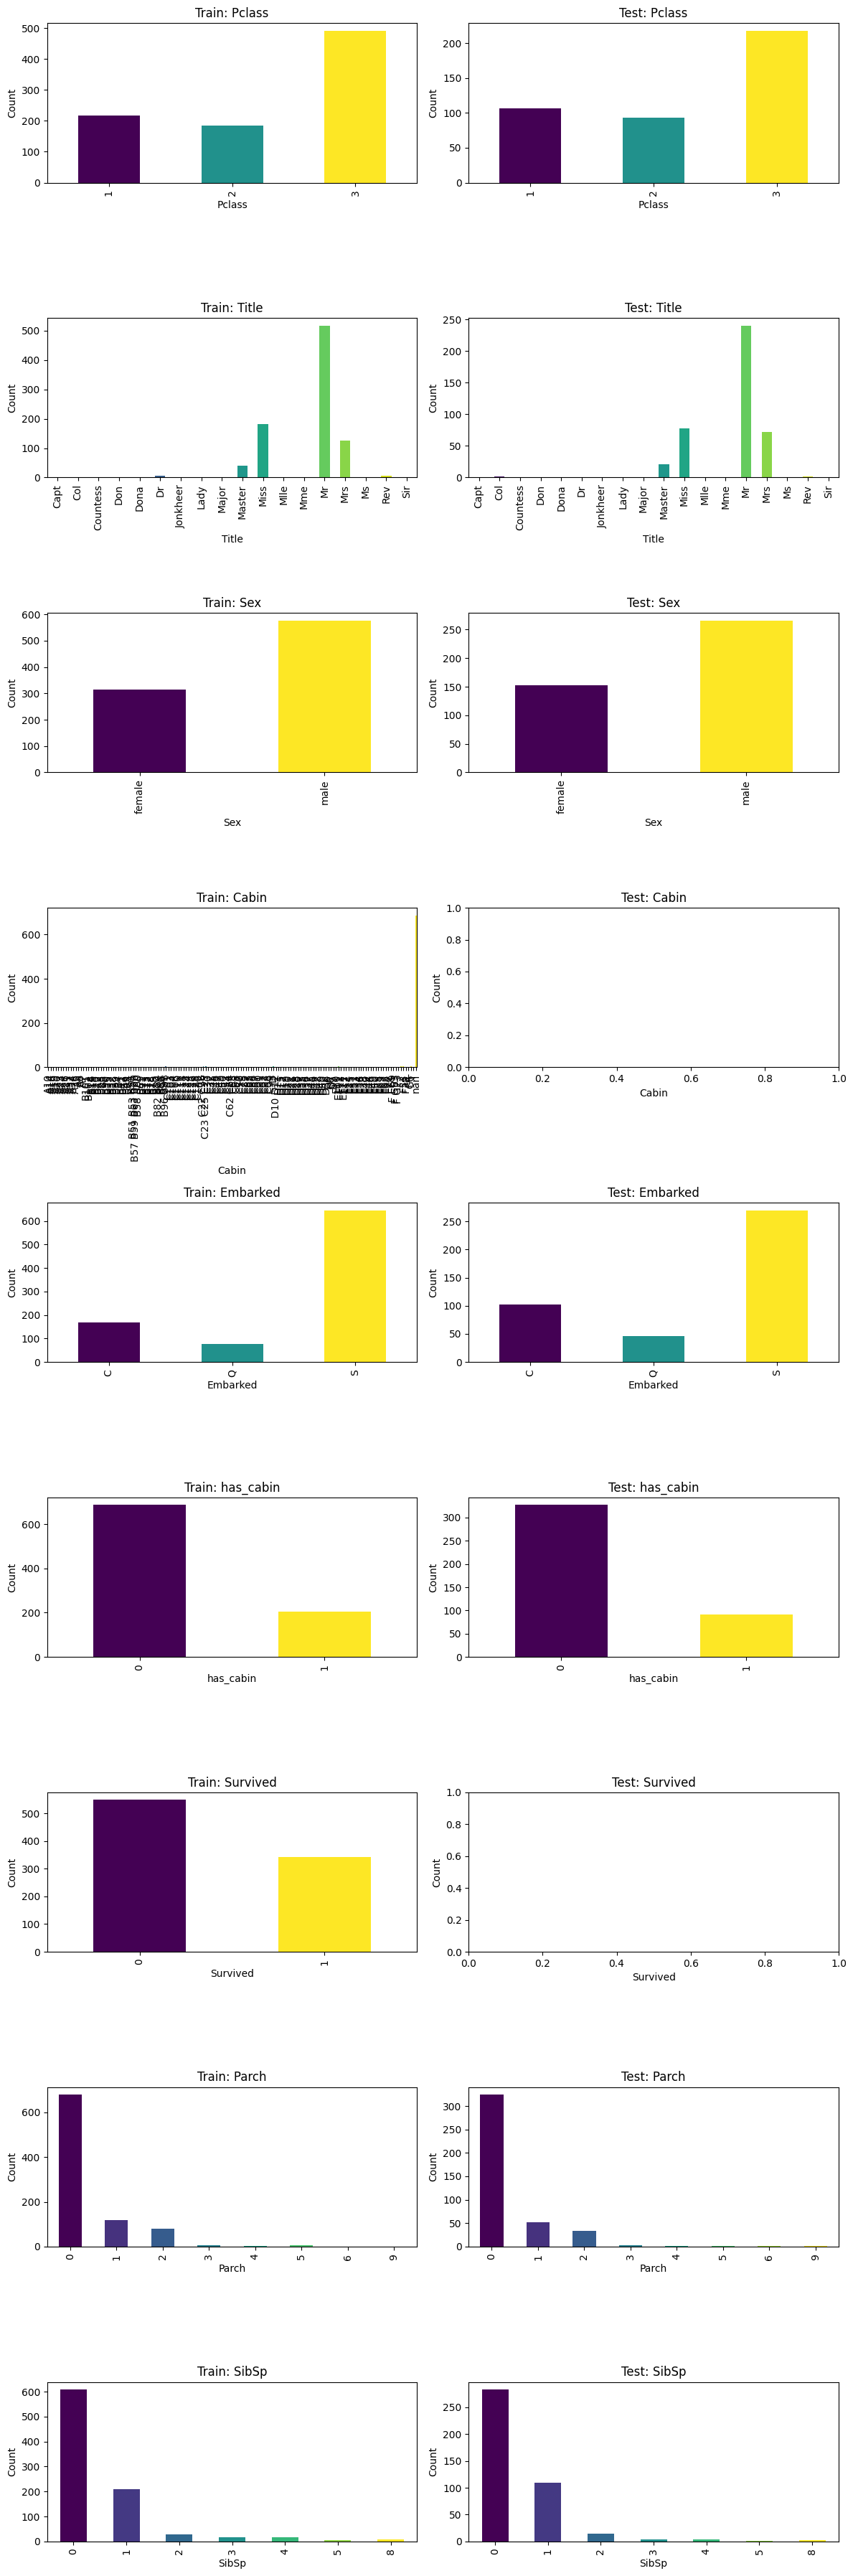

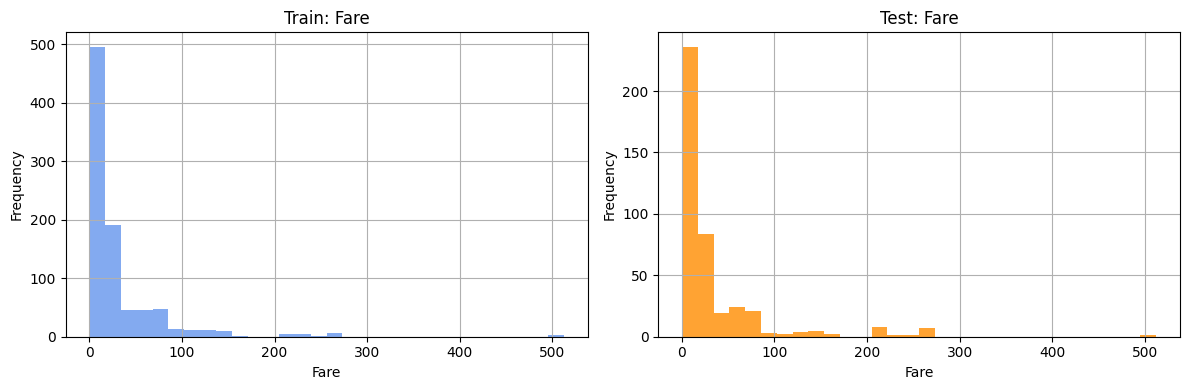

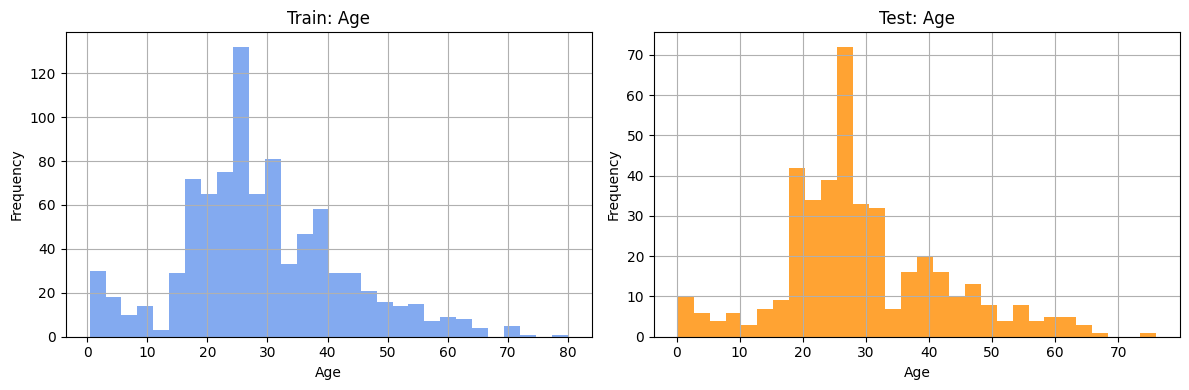

In [25]:
# Compare train_data vs test_data by plotting side-by-side for each feature

# Identify column types based on the *union* of both datasets where possible
cat_cols = list(set(
    train_data.select_dtypes(include=["category", "object"]).columns.tolist() +
    test_data.select_dtypes(include=["category", "object"]).columns.tolist()
))
int_cols = list(set(
    train_data.select_dtypes(include=["int", "int64", "int32", "uint8"]).columns.tolist() +
    test_data.select_dtypes(include=["int", "int64", "int32", "uint8"]).columns.tolist()
))
float_cols = list(set(
    train_data.select_dtypes(include=["float", "float64", "float32"]).columns.tolist() +
    test_data.select_dtypes(include=["float", "float64", "float32"]).columns.tolist()
))

import math

# Barplots for categorical and integer columns (one row = one feature; left=Train, right=Test)
barplot_cols = cat_cols + int_cols
n_cols = 2  # Left: Train, Right: Test
n_rows = len(barplot_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
if n_rows == 1:
    axes = np.array([axes])

for row_idx, col in enumerate(barplot_cols):
    # Train data
    train_vc = train_data[col].value_counts(dropna=False).sort_index() if col in train_data else pd.Series()
    test_vc = test_data[col].value_counts(dropna=False).sort_index() if col in test_data else pd.Series()
    # For colors, map to same palette for consistent comparison

    # FIX: Sort with all values as strings to avoid TypeError on mixed dtype sorting
    all_idx = sorted(set(train_vc.index).union(test_vc.index), key=lambda x: str(x))
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_idx)))
    color_map = dict(zip(all_idx, colors))

    ax_train = axes[row_idx, 0]
    ax_test  = axes[row_idx, 1]

    if len(train_vc) > 0:
        train_vc.reindex(all_idx, fill_value=0).plot(kind='bar', ax=ax_train,
                                                     color=[color_map[x] for x in all_idx])
    ax_train.set_title(f'Train: {col}')
    ax_train.set_xlabel(col)
    ax_train.set_ylabel('Count')

    if len(test_vc) > 0:
        test_vc.reindex(all_idx, fill_value=0).plot(kind='bar', ax=ax_test,
                                                    color=[color_map[x] for x in all_idx])
    ax_test.set_title(f'Test: {col}')
    ax_test.set_xlabel(col)
    ax_test.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Histograms for float columns (one row per float column: left=Train, right=Test)
for col in float_cols:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    # Train
    if col in train_data:
        train_data[col].hist(bins=30, ax=axes[0], color='cornflowerblue', alpha=0.8)
    axes[0].set_title(f'Train: {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Test
    if col in test_data:
        test_data[col].hist(bins=30, ax=axes[1], color='darkorange', alpha=0.8)
    axes[1].set_title(f'Test: {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
